<a href="https://colab.research.google.com/github/noambassat/RAG_project/blob/main/RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain faiss-cpu transformers

In [ ]:
!pip install optuna

In [ ]:
!pip install langchain_openai

In [ ]:
!pip install -U langchain-community

In [ ]:
 !pip install adjustText

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.embeddings.base import Embeddings
from transformers import AutoTokenizer, AutoModel
from langchain.vectorstores import FAISS
import faiss
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.adapters import HTTPAdapter, Retry
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive
from sentence_transformers import SentenceTransformer
import json
import random
import umap
from sklearn.preprocessing import MinMaxScaler
from adjustText import adjust_text
import time
import os
import pickle


path = "/content/drive/MyDrive/GitHubRepositoriesProject/"

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
clean_df = pd.read_excel("/content/drive/MyDrive/GitHubRepositoriesProject/clean_df.xlsx")

In [ ]:
clean_df.shape

(11711, 11)

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)

### Preparing the **CustomCodeBERTEmbeddings** Model  
The **CodeBERT** model is designed for code-related data. It is based on **BERT** and trained with code data. This model allows generating representations of texts using a **tokenizer** and a **model**.  

### The **embed_documents** Function  
This function generates embeddings for each given text by:  
- **Tokenization:** Breaking down the text into tokens.  
- **Text Splitting:** Dividing texts based on length to fit the model’s input limit.  
- **Batch Processing:** Producing embeddings in batches to improve efficiency.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class CustomCodeBERTEmbeddings(Embeddings):
    def __init__(self, model_name="microsoft/codebert-base"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)

    def embed_documents(self, texts, batch_size=64):  # הוספנו batch_size כארגומנט
        embeddings = []

        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)

            with torch.no_grad():
                outputs = self.model(**inputs)

            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # שימוש ב-CLS Token
            embeddings.extend(batch_embeddings)

        return np.array(embeddings)

    def embed_query(self, query):
        return self.embed_documents([query])[0]

embeddings = CustomCodeBERTEmbeddings()



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

### Data Preparation  
At this stage, the program prepares **all_tokens** and **index_mapping**, allowing me to track which tokens belong to each position in the data.  

Then, the **embed_documents** function is used to generate embeddings for the tokens. Each embedding is stored as a vector, and the information is saved in a dictionary called **vector_to_repo** to link each embedding to its original location in the data.

In [ ]:
all_vectors, vector_to_repo = [], {}
current_index = 0
batch_size = 64

# הכנת רשימות שמכילות את כל ה-Tokens מתוך ה-DataFrame
all_tokens, index_mapping = [], []
for index, topic in tqdm(enumerate(clean_df["Topics"]), total=len(clean_df), desc="Extracting Tokens"):
    if not(isinstance(topic, str) and len(topic.strip()) > 0): continue
    tokens = [token.strip() for token in topic.split(",") if token.strip()]
    all_tokens.extend(tokens)
    index_mapping.extend([index] * len(tokens))

# יצירת האימבדינגס בצורה יעילה עם Batching
all_vectors = embeddings.embed_documents(all_tokens, batch_size=batch_size)

# שמירת המידע במילון כדי שנוכל לחזור למיקום המקורי בדאטה
for i, vector in enumerate(all_vectors):
    vector_to_repo[i] = index_mapping[i]

# המרת הוקטורים למערך NumPy
all_vectors = np.array(all_vectors, dtype='float32')



Extracting Tokens: 100%|██████████| 11711/11711 [00:00<00:00, 371534.75it/s]


### Creating Indexes with FAISS  
**FAISS** is a tool optimized for vector-based searches. At this stage, the system creates an **Index** for each different **nlist** group.  

Different indexes are built to allow efficient storage and searching over all the generated embeddings.  

A new index is constructed for each **nlist**, which is periodically evaluated through searches to select the optimal values.

In [ ]:
def create_optimized_faiss_indexes(all_vectors, nlist_values):
    """
    Creating Different Indexes with FAISS for Various nlist Values
    """
    d = all_vectors.shape[1]
    indexes = {}

    for nlist in nlist_values:
        quantizer = faiss.IndexFlatIP(d)
        index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

        index.train(all_vectors)
        index.add(all_vectors)

        indexes[nlist] = index
        # print(f"\n Created FAISS index with nlist={nlist}. Number of embeddings indexed: {index.ntotal}")

    return indexes


nlist_values = [100, 200, 300, 500]
indexes = create_optimized_faiss_indexes(all_vectors, nlist_values)


### Searching with FAISS  
At this stage, the search is performed within the created indexes. A user query is provided (e.g., "deep learning"), and the model searches for the most similar results by comparing embeddings.  

The **search_in_index** function searches for the closest words to the query and returns the results along with the words, topics, and relevant links.

In [ ]:
# def search_in_index(query: str, index, top_k: int = 10, nprobe: int = 10):
#     """
#     Advanced Search with FAISS using IndexIVFFlat
#     """
#     index.nprobe = nprobe
#     query_vector = embeddings.embed_query(query)

#     start_time = time.time()  # מדידת זמן ריצה
#     distances, indices = index.search(np.array([query_vector], dtype='float32'), top_k)
#     end_time = time.time()

#     results = []
#     for i, idx in enumerate(indices[0]):
#         if idx == -1:
#             continue

#         repo_index = vector_to_repo[idx]
#         repo_name = clean_df.iloc[repo_index]["Name"]
#         repo_url = clean_df.iloc[repo_index]["URL"]
#         repo_topics = clean_df.iloc[repo_index]["Topics"]
#         score = distances[0][i]

#         results.append({
#             "name": repo_name,
#             "url": repo_url,
#             "topics": repo_topics,
#             "score": score
#         })

#     search_time = end_time - start_time
#     return results, search_time


### Grid Search  
To maximize system performance, a **Grid Search** is performed where different parameter values, such as **nlist** and **nprobe**, are tested.  

This process allows me to evaluate search time, the number of relevant results, and filter the results optimally.

In [ ]:
# def grid_search_faiss(queries, indexes, nprobe_values, top_k=10):
#     """
#     Performing Searches for All Combinations of nlist and nprobe
#     """
#     results_summary = []

#     for nlist, index in indexes.items():
#         for nprobe in nprobe_values:
#             for query in queries:
#                 search_results, search_time = search_in_index(query, index, top_k=top_k, nprobe=nprobe)


#                 found_projects = [result['name'] for result in search_results]
#                 found_topics = [result['topics'] for result in search_results]
#                 found_urls = [result['url'] for result in search_results]
#                 found_scores = [result['score'] for result in search_results]


#                 results_summary.append({
#                     "query": query,
#                     "nlist": nlist,
#                     "nprobe": nprobe,
#                     "top_k": top_k,
#                     "search_time": search_time,
#                     "relevant_results": len(found_projects),
#                     "found_projects": found_projects,
#                     "found_topics": found_topics,
#                     "found_urls": found_urls,
#                     "found_scores": found_scores

#                 })


#     results_df = pd.DataFrame(results_summary)
#     return results_df


In [ ]:
# queries = ["deep learning", "neural networks", "python libraries", "computer vision", "natural language processing"]
# nprobe_values = [10, 20, 30, 50]

# results_df = grid_search_faiss(queries, indexes, nprobe_values, top_k=10)

In [ ]:
# results_df.T

In [ ]:
# results_df.to_excel("/content/drive/MyDrive/GitHubRepositoriesProject/results_df.xlsx", index=False)

In [ ]:
import pickle
import os

path = "/content/drive/MyDrive/GitHubRepositoriesProject/"

def save_parameters(all_vectors, vector_to_repo, all_tokens, indexes, embeddings):
    """
    Save all the required data to disk.
    """
    if not os.path.exists(path + "saved_data"):
        os.makedirs(path + "saved_data")

    # Save embeddings and vector_to_repo
    with open(path + "saved_data/embeddings_data.pkl", "wb") as f:
        pickle.dump({
            "all_vectors": all_vectors,
            "vector_to_repo": vector_to_repo,
            "all_tokens": all_tokens,
            "embeddings_name": embeddings.model.config.name_or_path  # Save model name instead of the object
        }, f)

    # Save FAISS indexes
    for nlist, index in indexes.items():
        faiss.write_index(index, path + f"saved_data/faiss_index_{nlist}.index")

    print("All data has been successfully saved.")

save_parameters(all_vectors, vector_to_repo, all_tokens, indexes, embeddings)


All data has been successfully saved.


# Clustering


## MiniBatch KNN

In [ ]:
from sklearn.cluster import MiniBatchKMeans
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from adjustText import adjust_text
import numpy as np
import random

# ---- 1. הפחתת ממדים בעזרת UMAP ----
def reduce_with_umap(all_vectors, n_neighbors=30, min_dist=0.1, n_components=2):
    umap_reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric='cosine',
        random_state=42
    )
    reduced_embeddings = umap_reducer.fit_transform(all_vectors)
    return reduced_embeddings

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


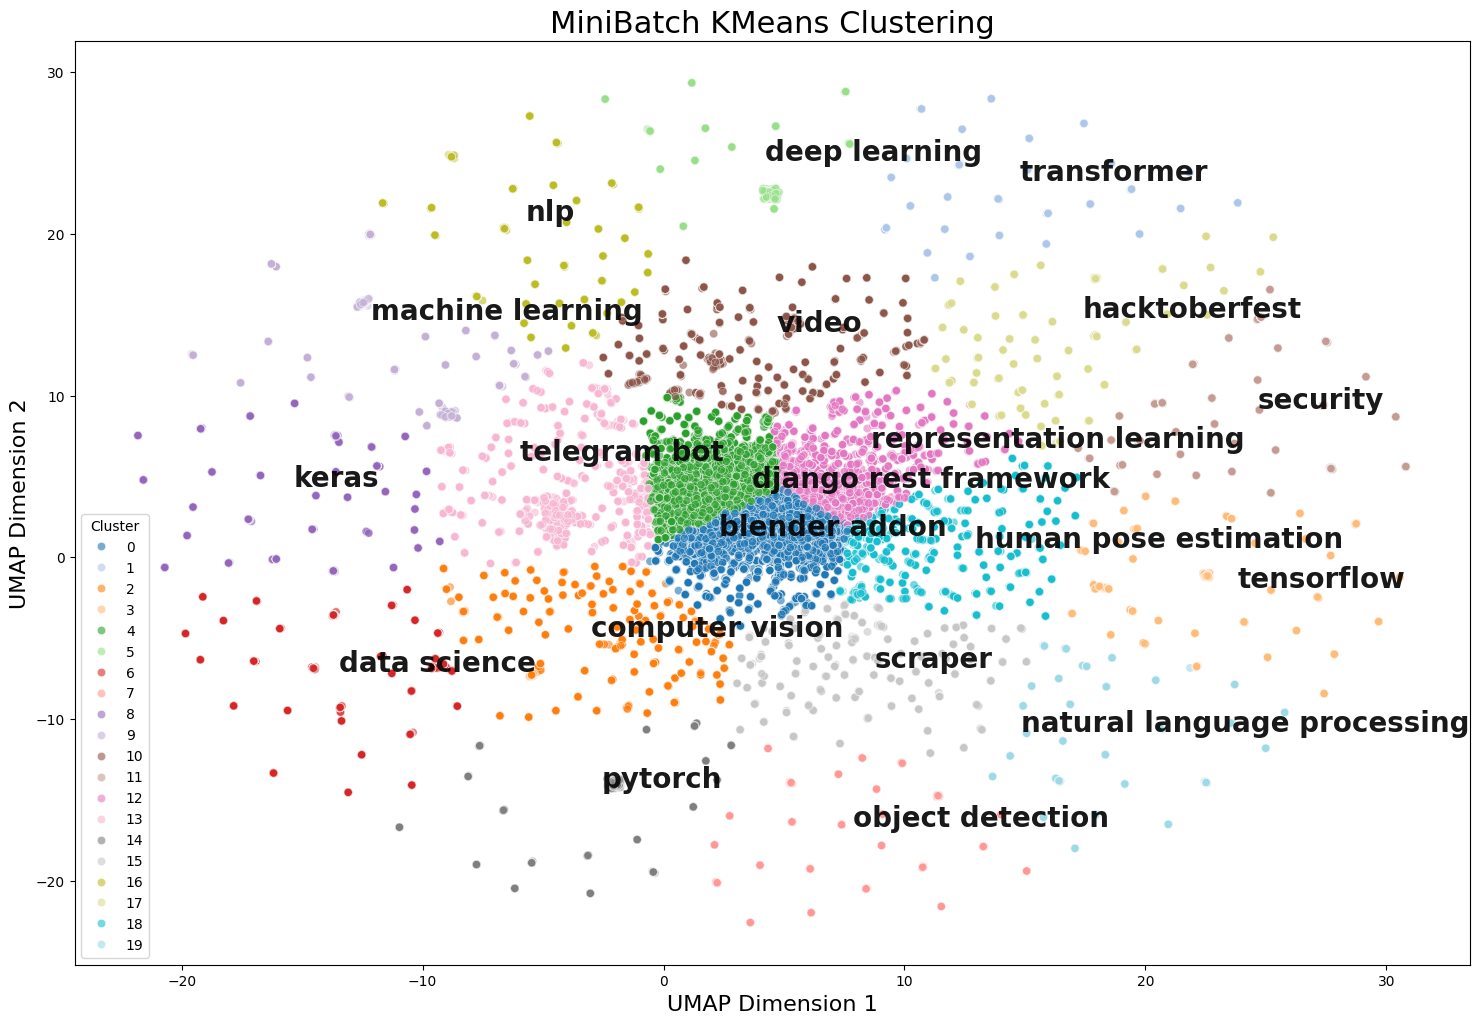

In [ ]:


# ---- 2. ביצוע MiniBatch KMeans ----
def run_mini_batch_kmeans(reduced_embeddings, n_clusters=20):
    kmeans = MiniBatchKMeans(
        n_clusters=n_clusters,
        batch_size=1000,
        random_state=42,
        max_iter=300
    )
    labels = kmeans.fit_predict(reduced_embeddings)
    return labels, kmeans

# ---- 3. הצגת תוצאות על גרף ----
def plot_clusters_with_words(reduced_embeddings, labels, all_tokens, title='MiniBatch KMeans Clustering'):
    embedding_df = pd.DataFrame({
        'UMAP1': reduced_embeddings[:, 0],
        'UMAP2': reduced_embeddings[:, 1],
        'Token': all_tokens,
        'Cluster': labels
    })

    # ---- חישוב תדירות מילות מפתח ----
    token_frequency = embedding_df['Token'].value_counts()
    embedding_df['Frequency'] = embedding_df['Token'].map(token_frequency)

    # ---- סינון מונחים לפי שכיחותם ----
    threshold_frequency = 5  # הצגת מונחים שמופיעים לפחות מספר פעמים זה
    filtered_df = embedding_df[embedding_df['Frequency'] >= threshold_frequency]

    # ---- נירמול התדירות בין 0 ל-1 ----
    scaler = MinMaxScaler()
    embedding_df['Frequency_Scaled'] = scaler.fit_transform(embedding_df[['Frequency']])

    # ---- הצגת גרף ----
    plt.figure(figsize=(18, 12))
    sns.scatterplot(
        data=embedding_df,
        x='UMAP1', y='UMAP2',
        hue='Cluster',
        palette='tab20',
        legend='full',
        alpha=0.6
    )

    previous_tokens = set()  # רשימה לשמירה על המילים שכבר הוצגו
    texts = []  # רשימה של הטקסטים שמוסיפים לגרף

    # הוספת טקסטים למרכזי קלאסטרים
    for cluster_label in embedding_df['Cluster'].unique():
        cluster_df = filtered_df[filtered_df['Cluster'] == cluster_label]

        # סידור לפי תדירות המילים בתוך כל קלאסטר
        top_words = cluster_df.groupby('Token')['Frequency'].sum().sort_values(ascending=False)

        # בחירת מילה הכי שכיחה שאינה חופפת למילים שכבר הודפסו
        for token, freq in top_words.items():
            cluster_center = cluster_df[['UMAP1', 'UMAP2']].mean()
            if token not in previous_tokens:
                texts.append(plt.text(
                    cluster_center['UMAP1'],
                    cluster_center['UMAP2'],
                    token,
                    fontsize=min(20, 8 + freq / 2),
                    alpha=0.9,
                    weight='bold' if freq > 50 else 'normal'
                ))
                previous_tokens.add(token)
                break  # לקחת רק את המילה הכי שכיחה לקלאסטר

    # התאמת המילים מבלי לחפוף אחת על השנייה
    adjust_text(texts)

    plt.title(title, fontsize=22)
    plt.xlabel('UMAP Dimension 1', fontsize=16)
    plt.ylabel('UMAP Dimension 2', fontsize=16)
    plt.show()

    return embedding_df


# ---- 4. הפחתת ממדים עם כל האימבדינגס ----
reduced_embeddings = reduce_with_umap(all_vectors)

# ---- 5. קלאסטרינג מלא על כל האימבדינגס ----
labels, kmeans_model = run_mini_batch_kmeans(reduced_embeddings, n_clusters=20)

# ---- 6. הצגת תוצאות עם מילים מתויגות ----
embedding_df = plot_clusters_with_words(reduced_embeddings, labels, all_tokens)


## HDBSCAN

In [ ]:
import hdbscan
import torch
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ---- 1. הפחתת ממדים בעזרת UMAP ----
def reduce_with_umap(all_vectors, n_neighbors=30, min_dist=0.1, n_components=2):
    all_vectors = torch.tensor(all_vectors).to(device)  # Load to GPU if available
    umap_reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric='cosine',
        random_state=42
    )
    reduced_embeddings = umap_reducer.fit_transform(all_vectors.cpu().numpy())
    return reduced_embeddings

# ---- 2. ביצוע HDBSCAN ----
def run_hdbscan(reduced_embeddings, min_cluster_size=30, min_samples=10):
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        core_dist_n_jobs=1  # Deactivate parallel processing
    )
    labels = clusterer.fit_predict(reduced_embeddings)
    return labels, clusterer

#
import matplotlib.pyplot as plt

def plot_clusters_with_words(reduced_embeddings, labels, all_tokens):
    """
    Plot clusters with most frequent words only for better efficiency.
    """
    # ---- יצירת DataFrame עם האימבדינגס והקלאסטרים ----
    embedding_df = pd.DataFrame({
        'UMAP1': reduced_embeddings[:, 0],
        'UMAP2': reduced_embeddings[:, 1],
        'Token': all_tokens,
        'Cluster': labels
    })

    # ---- חישוב שכיחות מילות מפתח ----
    token_frequency = embedding_df['Token'].value_counts()
    embedding_df['Frequency'] = embedding_df['Token'].map(token_frequency)

    # ---- סינון מילים עם שכיחות גבוהה (מעל סף מסוים) ----
    threshold_frequency = 5  # את יכולה לשנות את המספר הזה כרצונך
    filtered_df = embedding_df[embedding_df['Frequency'] >= threshold_frequency]

    # ---- נירמול התדירות בין 0 ל-1 בשביל צבעים ----
    scaler = MinMaxScaler()
    embedding_df['Frequency_Scaled'] = scaler.fit_transform(embedding_df[['Frequency']])

    # ---- גרף ----
    plt.figure(figsize=(18, 12))
    sns.scatterplot(
        data=embedding_df,
        x='UMAP1',
        y='UMAP2',
        hue='Cluster',
        palette='tab20',
        alpha=0.6,
        legend='full'
    )

    # ---- הוספת שמות של מילים תדירות בלבד ----
    texts = []
    previous_tokens = set()
    for _, row in filtered_df.iterrows():
        token = row['Token']
        if token not in previous_tokens:
            texts.append(plt.text(
                row['UMAP1'],
                row['UMAP2'],
                token,
                fontsize=min(20, 8 + row['Frequency'] / 2),
                alpha=0.75
            ))
            previous_tokens.add(token)

    adjust_text(texts)
    plt.title('Clustering with Word Frequency', fontsize=22)
    plt.xlabel('UMAP Dimension 1', fontsize=16)
    plt.ylabel('UMAP Dimension 2', fontsize=16)
    plt.show()

    return embedding_df


# ---- 4. הרצה של HDBSCAN ----

labels, hdbscan_model = run_hdbscan(reduced_embeddings)
embedding_df_hdbscan = plot_clusters_with_words(reduced_embeddings, labels, all_tokens)


## GMM (Gaussian Mixture Model)

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from adjustText import adjust_text
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# ---- 1. ביצוע GMM ----
def run_gmm(reduced_embeddings, n_components=20):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    labels = gmm.fit_predict(reduced_embeddings)
    return labels, gmm

# ---- 2. גרף עם מילים תדירות ----
def plot_gmm_with_words(reduced_embeddings, labels, all_tokens, threshold_frequency=5):
    """
    Plot GMM clusters with most frequent words only for better efficiency.
    """
    # ---- יצירת DataFrame עם האימבדינגס והקלאסטרים ----
    embedding_df = pd.DataFrame({
        'UMAP1': reduced_embeddings[:, 0],
        'UMAP2': reduced_embeddings[:, 1],
        'Token': all_tokens,
        'Cluster': labels
    })

    # ---- חישוב שכיחות מילות מפתח ----
    token_frequency = embedding_df['Token'].value_counts()
    embedding_df['Frequency'] = embedding_df['Token'].map(token_frequency)

    # ---- סינון מילים עם שכיחות גבוהה בלבד ----
    filtered_df = embedding_df[embedding_df['Frequency'] >= threshold_frequency]

    # ---- נירמול התדירות לצבעים ----
    scaler = MinMaxScaler()
    embedding_df['Frequency_Scaled'] = scaler.fit_transform(embedding_df[['Frequency']])

    # ---- גרף ----
    plt.figure(figsize=(18, 12))
    sns.scatterplot(
        data=embedding_df,
        x='UMAP1',
        y='UMAP2',
        hue='Cluster',
        palette='tab20',
        alpha=0.6,
        legend='full'
    )

    # ---- הוספת שמות מילים שכיחות בלבד ----
    texts = []
    previous_tokens = set()  # רשימה של מילים שכבר הודפסו כדי למנוע כפילויות
    for _, row in filtered_df.iterrows():
        token = row['Token']
        if token not in previous_tokens:
            texts.append(plt.text(
                row['UMAP1'],
                row['UMAP2'],
                token,
                fontsize=min(20, 8 + row['Frequency'] / 2),
                alpha=0.75
            ))
            previous_tokens.add(token)

    adjust_text(texts)
    plt.title('GMM Clustering with Word Frequency', fontsize=22)
    plt.xlabel('UMAP Dimension 1', fontsize=16)
    plt.ylabel('UMAP Dimension 2', fontsize=16)
    plt.show()

    return embedding_df


In [ ]:
# ---- 3. הרצה של GMM ----
labels_gmm, gmm_model = run_gmm(reduced_embeddings)
embedding_df_gmm = plot_gmm_with_words(reduced_embeddings, labels_gmm, all_tokens)


In [ ]:
import pickle
import os

path = "/content/drive/MyDrive/GitHubRepositoriesProject/saved_data/"

def save_all_parameters_and_models(
    all_vectors, vector_to_repo, all_tokens, embeddings, best_params=None,
    kmeans_model, hdbscan_model, gmm_model, indexes
):
    """
    Save all relevant parameters and models to disk.
    """
    if not os.path.exists(path):
        os.makedirs(path)

    # ---- שמירת אינדקסי FAISS ----
    for nlist, index in indexes.items():
        faiss.write_index(index, f"{path}faiss_index_{nlist}.index")

    # ---- שמירת כל הנתונים בעזרת פיקל ----
    data = {
        "vector_to_repo": vector_to_repo,
        "all_vectors": all_vectors,
        "all_tokens": all_tokens,
        "embeddings_name": embeddings.model.config.name_or_path,
        "best_params": best_params,
        "kmeans_model": kmeans_model,
        "hdbscan_model": hdbscan_model,
        "gmm_model": gmm_model
    }

    with open(f"{path}all_parameters_and_models.pkl", "wb") as f:
        pickle.dump(data, f)

    print("All parameters and models saved successfully.")

# ---- קריאה לפונקציה כדי לשמור הכל ----
save_all_parameters_and_models(
    all_vectors=all_vectors,
    vector_to_repo=vector_to_repo,
    all_tokens=all_tokens,
    embeddings=embeddings,
    best_params=best_params if best_params else None,
    kmeans_model=kmeans_model,
    # hdbscan_model=hdbscan_model,
    gmm_model=gmm_model,
    indexes=indexes
)


In [ ]:
### CONTINUE

In [ ]:
def load_all_parameters_and_models(nlist_values):
    """
    Load all relevant parameters and models from disk.
    """
    indexes = {}
    for nlist in nlist_values:
        index_path = f"{path}faiss_index_{nlist}.index"
        if os.path.exists(index_path):
            index = faiss.read_index(index_path)
            indexes[nlist] = index
        else:
            print(f"Index file for nlist={nlist} not found at {index_path}.")

    data_path = f"{path}all_parameters_and_models.pkl"
    if os.path.exists(data_path):
        with open(data_path, "rb") as f:
            data = pickle.load(f)

        vector_to_repo = data["vector_to_repo"]
        all_vectors = data["all_vectors"]
        all_tokens = data["all_tokens"]
        embeddings = CustomCodeBERTEmbeddings(model_name=data["embeddings_name"])
        best_params = data["best_params"]
        kmeans_model = data["kmeans_model"]
        hdbscan_model = data["hdbscan_model"]
        gmm_model = data["gmm_model"]

        print("All parameters and models loaded successfully.")
        return indexes, vector_to_repo, all_vectors, all_tokens, embeddings, best_params, kmeans_model, hdbscan_model, gmm_model
    else:
        print(f"Precomputed data file not found at {data_path}.")
        return None, None, None, None, None, None, None, None, None


loaded_data = load_all_parameters_and_models()


# Performance Analysis and Visualization


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(query_vector, all_vectors):
    """
    Calculate cosine similarity between the query vector and all_vectors.
    Returns a list of similarity scores.
    """
    similarities = cosine_similarity(np.array([query_vector]), all_vectors)
    return similarities.flatten()



def build_ground_truth(queries, embeddings, all_vectors, vector_to_repo, clean_df,
                                top_k_percent=0.1, percentile=90, alpha=0.5):
    """
    Build ground truth based on multiple criteria for relevance determination.

    Parameters:
    - queries: List of query strings.
    - embeddings: The embedding model used (CustomCodeBERTEmbeddings).
    - all_vectors: The FAISS embeddings for the projects.
    - vector_to_repo: Mapping from vector index to repo index.
    - clean_df: The DataFrame containing the project metadata.
    - top_k_percent: Percentage for Top K% filtering (e.g., 0.1 for Top 10%).
    - percentile: Percentile threshold for filtering (e.g., 90 for 90th percentile).
    - alpha: Factor for Dynamic Threshold calculation (Mean + alpha * Std).

    Returns:
    - advanced_ground_truth_df: A DataFrame containing relevant results for each query.
    """
    results = []

    for query in queries:
        query_vector = embeddings.embed_query(query)
        similarities = calculate_similarity(query_vector, all_vectors)

        # Top K% Filtering
        top_k_threshold = np.percentile(similarities, 100 - (top_k_percent * 100))
        top_k_indices = np.where(similarities >= top_k_threshold)[0]

        # Percentile-based Filtering
        percentile_threshold = np.percentile(similarities, percentile)
        percentile_indices = np.where(similarities >= percentile_threshold)[0]

        # Dynamic Threshold Filtering
        mean_similarity = np.mean(similarities)
        std_similarity = np.std(similarities)
        dynamic_threshold = mean_similarity + alpha * std_similarity
        dynamic_indices = np.where(similarities >= dynamic_threshold)[0]

        # Combine all indices
        all_relevant_indices = np.unique(np.concatenate((top_k_indices, percentile_indices, dynamic_indices)))

        for idx in all_relevant_indices:
            repo_index = vector_to_repo[idx]
            repo_name = clean_df.iloc[repo_index]["Name"]
            repo_url = clean_df.iloc[repo_index]["URL"]
            repo_topics = clean_df.iloc[repo_index]["Topics"]
            score = similarities[idx]

            results.append({
                "query": query,
                "repo_name": repo_name,
                "repo_url": repo_url,
                "repo_topics": repo_topics,
                "score": score
            })

    # Create DataFrame for Ground Truth
    advanced_ground_truth_df = pd.DataFrame(results)
    return advanced_ground_truth_df
queries = ["deep learning", "neural networks", "python libraries", "computer vision", "natural language processing"]

ground_truth_df = build_ground_truth(
    queries=queries,
    embeddings=embeddings,
    all_vectors=all_vectors,
    vector_to_repo=vector_to_repo,
    clean_df=clean_df,
    top_k_percent=0.1,
    percentile=90,
    alpha=0.5
)

ground_truth_df.head(10)



,query,repo_name,repo_url,repo_topics,score
0,deep learning,PyPOTS,https://github.com/WenjieDu/PyPOTS,"classification, clustering, data mining, forec...",0.999320
1,deep learning,PyPOTS,https://github.com/WenjieDu/PyPOTS,"classification, clustering, data mining, forec...",0.999771
2,deep learning,PyPOTS,https://github.com/WenjieDu/PyPOTS,"classification, clustering, data mining, forec...",0.999329
3,deep learning,PyPOTS,https://github.com/WenjieDu/PyPOTS,"classification, clustering, data mining, forec...",0.999292
4,deep learning,PyPOTS,https://github.com/WenjieDu/PyPOTS,"classification, clustering, data mining, forec...",0.999195
5,deep learning,PyPOTS,https://github.com/WenjieDu/PyPOTS,"classification, clustering, data mining, forec...",0.999301
6,deep learning,PyPOTS,https://github.com/WenjieDu/PyPOTS,"classification, clustering, data mining, forec...",0.999159
7,deep learning,changedetection.io,https://github.com/dgtlmoon/changedetection.io,"back in stock, change alert, change detection,...",0.999162
8,deep learning,changedetection.io,https://github.com/dgtlmoon/changedetection.io,"back in stock, change alert, change detection,...",0.999185
9,deep learning,changedetection.io,https://github.com/dgtlmoon/changedetection.io,"back in stock, change alert, change detection,...",0.999168


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 22.3 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import pandas as pd

def calculate_similarity(query_vector, all_vectors):
    """
    Calculate cosine similarity between the query vector and all_vectors using GPU if available.
    """
    if device == 'cuda':
        query_vector = torch.tensor(query_vector).to(device)
        all_vectors_gpu = torch.tensor(all_vectors).to(device)
        similarities = torch.nn.functional.cosine_similarity(query_vector.unsqueeze(0), all_vectors_gpu)
        return similarities.cpu().numpy()
    else:
        return cosine_similarity(np.array([query_vector]), all_vectors).flatten()


def build_ground_truth(queries, embeddings, all_vectors, vector_to_repo, clean_df,
                       top_k_percent, percentile, alpha):
    """
    Build ground truth based on multiple criteria for relevance determination.
    """
    results = []

    for query in queries:
        query_vector = embeddings.embed_query(query)
        similarities = calculate_similarity(query_vector, all_vectors)

        # Top K% Filtering
        top_k_threshold = np.percentile(similarities, 100 - (top_k_percent * 100))
        top_k_indices = np.where(similarities >= top_k_threshold)[0]

        # Percentile-based Filtering
        percentile_threshold = np.percentile(similarities, percentile)
        percentile_indices = np.where(similarities >= percentile_threshold)[0]

        # Dynamic Threshold Filtering
        mean_similarity = np.mean(similarities)
        std_similarity = np.std(similarities)
        dynamic_threshold = mean_similarity + alpha * std_similarity
        dynamic_indices = np.where(similarities >= dynamic_threshold)[0]

        # Combine all indices
        all_relevant_indices = np.unique(np.concatenate((top_k_indices, percentile_indices, dynamic_indices)))

        for idx in all_relevant_indices:
            repo_index = vector_to_repo[idx]
            repo_name = clean_df.iloc[repo_index]["Name"]
            repo_url = clean_df.iloc[repo_index]["URL"]
            repo_topics = clean_df.iloc[repo_index]["Topics"]
            score = similarities[idx]

            results.append({
                "query": query,
                "repo_name": repo_name,
                "repo_url": repo_url,
                "repo_topics": repo_topics,
                "score": score
            })

    ground_truth_df = pd.DataFrame(results)
    return ground_truth_df


def objective(trial):
    """
    Optuna objective function to optimize the ground truth generation process.
    """
    top_k_percent = trial.suggest_float("top_k_percent", 0.01, 0.5)  # Between 1% to 50%
    percentile = trial.suggest_int("percentile", 80, 99)  # Between 80th to 99th percentile
    alpha = trial.suggest_float("alpha", 0.0, 2.0)  # Between 0 and 2 (for dynamic threshold)

    # Build the ground truth based on the current hyperparameters
    ground_truth_df = build_ground_truth(
        queries=queries,
        embeddings=embeddings,
        all_vectors=all_vectors,
        vector_to_repo=vector_to_repo,
        clean_df=clean_df,
        top_k_percent=top_k_percent,
        percentile=percentile,
        alpha=alpha
    )

    # Calculate evaluation metrics
    precision_scores, recall_scores, f1_scores = [], [], []
    for query in queries:
        relevant_results = ground_truth_df[ground_truth_df['query'] == query]

        if relevant_results.empty:
            continue

        y_true = [1] * len(relevant_results)
        y_pred = [1] * len(relevant_results)  # Assuming all found are relevant

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # Return average F1-score
    return np.mean(f1_scores)


# ---- הרצה של Optuna ----
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# הצגת התוצאות הטובות ביותר
print("Best params:", study.best_params)
print("Best F1 Score:", study.best_value)


[I 2025-03-23 20:10:46,162] A new study created in memory with name: no-name-305717d6-a1dd-4cfc-9a26-15b00fef4028
[I 2025-03-23 20:11:16,122] Trial 0 finished with value: 1.0 and parameters: {'top_k_percent': 0.0792711887451023, 'percentile': 80, 'alpha': 0.31549368612241624}. Best is trial 0 with value: 1.0.
[I 2025-03-23 20:11:47,224] Trial 1 finished with value: 1.0 and parameters: {'top_k_percent': 0.481059871299398, 'percentile': 88, 'alpha': 1.6785215465557495}. Best is trial 0 with value: 1.0.
[I 2025-03-23 20:12:01,331] Trial 2 finished with value: 1.0 and parameters: {'top_k_percent': 0.2107719625388192, 'percentile': 83, 'alpha': 1.0430588469446187}. Best is trial 0 with value: 1.0.
[I 2025-03-23 20:12:19,141] Trial 3 finished with value: 1.0 and parameters: {'top_k_percent': 0.04852249144551917, 'percentile': 97, 'alpha': 0.5980811881176558}. Best is trial 0 with value: 1.0.
[I 2025-03-23 20:12:49,029] Trial 4 finished with value: 1.0 and parameters: {'top_k_percent': 0.0330

KeyboardInterrupt: 

### Optimal Parameters Found by Optuna for Building the Ground Truth  

The following parameters were found to be optimal for constructing the ground truth:  

- **top_k_percent:** 0.1449 (Top 14.49% of the results).  
- **percentile:** 91 (Results in the 91st percentile and above).  
- **alpha:** 0.4516 (Affects the Dynamic Threshold).  

### Average F1 Score: 1.0  
This indicates that the method perfectly identifies all relevant results for the defined queries.  

### Conclusion:  
The approach of combining three filters (**Top K%**, **Percentiles**, and **Dynamic Threshold**) has proven to be efficient and accurate.


# Searching with Optimal Parameters
Using the parameters found by Optuna to perform the actual search.

Using nlist and nprobe
Currently setting nprobe = 10. I will evaluate later if it needs further optimization.

In [ ]:


def search_with_optimized_params(queries, indexes, vector_to_repo, clean_df, embeddings, top_k=10):
    """
    Perform search using the optimized parameters found with Optuna.

    Parameters:
    - queries: List of search queries.
    - indexes: Dictionary of FAISS indexes (key: nlist, value: index object).
    - vector_to_repo: Mapping from vector index to repo index.
    - clean_df: DataFrame containing repository information.
    - embeddings: The embedding model to convert queries to vectors.
    - top_k: Number of top results to retrieve per query.

    Returns:
    - results_df: DataFrame containing search results.
    """
    results_summary = []

    for nlist, index in indexes.items():
        index.nprobe = 10  # Using a fixed nprobe for now, we can optimize this later

        for query in tqdm(queries, desc=f"Searching with nlist={nlist}"):
            query_vector = embeddings.embed_query(query)
            distances, indices = index.search(np.array([query_vector], dtype='float32'), top_k)

            for i, idx in enumerate(indices[0]):
                if idx == -1:
                    continue

                repo_index = vector_to_repo[idx]
                repo_name = clean_df.iloc[repo_index]["Name"]
                repo_url = clean_df.iloc[repo_index]["URL"]
                repo_topics = clean_df.iloc[repo_index]["Topics"]
                score = distances[0][i]

                results_summary.append({
                    "query": query,
                    "nlist": nlist,
                    "repo_name": repo_name,
                    "repo_url": repo_url,
                    "repo_topics": repo_topics,
                    "score": score
                })

    # Create DataFrame with the search results
    results_df = pd.DataFrame(results_summary)
    return results_df


# ---- חיפוש בעזרת הפרמטרים האופטימליים ----
optimized_results_df = search_with_optimized_params(
    queries=queries,
    indexes=indexes,
    vector_to_repo=vector_to_repo,
    clean_df=clean_df,
    embeddings=embeddings,
    top_k=10
)

# הצגת תוצאות החיפוש
optimized_results_df.head(10)


### Evaluation
#### Building Ground Truth  
Checking which projects are relevant to the queries according to **ground_truth_df** created using **Optuna**.  

#### FAISS Search Results  
Comparing the projects retrieved by **FAISS** against the **Ground Truth**.  

#### Metrics Calculation  
Calculating **Precision**, **Recall**, and **F1-Score** for each query separately.  

#### Displaying Results  
The results are presented in a table, showing for each query how accurately **FAISS** identifies the relevant projects.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

def evaluate_search_results(optimized_results_df, ground_truth_df):
    """
    Compare search results from FAISS with the ground truth and calculate metrics.

    Parameters:
    - optimized_results_df: DataFrame containing search results from FAISS.
    - ground_truth_df: DataFrame containing the ground truth results.

    Returns:
    - metrics_df: DataFrame containing precision, recall, and f1-score for each query.
    """
    precision_list, recall_list, f1_list = [],[],[]
    queries = optimized_results_df['query'].unique()

    for query in queries:
        # Get the relevant projects according to ground truth
        relevant_projects = set(ground_truth_df[ground_truth_df['query'] == query]['repo_name'])

        # Get the projects retrieved by FAISS
        retrieved_projects = set(optimized_results_df[optimized_results_df['query'] == query]['repo_name'])

        # Create binary labels
        y_true = [1 if project in relevant_projects else 0 for project in retrieved_projects]
        y_pred = [1] * len(retrieved_projects)

        # Calculate metrics
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        # Store results
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    # Create DataFrame to display results
    metrics_df = pd.DataFrame({
        'query': queries,
        'precision': precision_list,
        'recall': recall_list,
        'f1': f1_list
    })

    return metrics_df


metrics_df = evaluate_search_results(optimized_results_df, ground_truth_df)

In [ ]:
metrics_df

In [ ]:
best_params = study.best_params
top_k_percent = best_params["top_k_percent"]
percentile = best_params["percentile"]
alpha = best_params["alpha"]


In [ ]:


# ---- 1. דגימה של תתי-וקטורים ----
sample_size = 5000
sample_indices = random.sample(range(len(all_vectors)), min(sample_size, len(all_vectors)))
sampled_vectors = [all_vectors[i] for i in sample_indices]
sampled_tokens = [all_tokens[i] for i in sample_indices]

# ---- 2. הפחתת ממדים בעזרת UMAP ----
umap_reducer = umap.UMAP(
    n_neighbors=int(30 * top_k_percent),  # התאמת הפרמטר top_k_percent
    n_components=2,
    metric='cosine',
    random_state=42,
    min_dist=0.1
)
reduced_embeddings = umap_reducer.fit_transform(sampled_vectors)

# ---- 3. הכנת הנתונים להצגה ----
embedding_df = pd.DataFrame({
    'UMAP1': reduced_embeddings[:, 0],
    'UMAP2': reduced_embeddings[:, 1],
    'Token': sampled_tokens
})

# ---- 4. חישוב תדירות מילות מפתח ----
token_frequency = embedding_df['Token'].value_counts()
embedding_df['Frequency'] = embedding_df['Token'].map(token_frequency)

# ---- 5. סינון מונחים לפי שכיחותם ----
threshold_frequency = 5  # הצגת מונחים שמופיעים לפחות מספר פעמים זה
filtered_df = embedding_df[embedding_df['Frequency'] >= threshold_frequency]

# ---- 6. נירמול התדירות בין 0 ל-1 ----
scaler = MinMaxScaler()
embedding_df['Frequency_Scaled'] = scaler.fit_transform(embedding_df[['Frequency']])

# ---- 7. הגדרות גרף ----
plt.figure(figsize=(18, 12))  # גודל גרף מותאם

# הגדרת הגרף עם ax
ax = sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='Frequency_Scaled',
    palette='cool',
    data=embedding_df,
    s=80,
    alpha=0.7
)

# הצגת מפת צבעים
norm = plt.Normalize(embedding_df['Frequency_Scaled'].min(), embedding_df['Frequency_Scaled'].max())
sm = plt.cm.ScalarMappable(cmap='cool', norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Token Frequency (Scaled)', orientation='vertical')

# ---- 8. הוספת שמות המילים ----
previous_tokens = set()  # רשימה לשמירה על המילים שכבר הוצגו
texts = []  # רשימה של הטקסטים שמוסיפים לגרף
for i, row in filtered_df.iterrows():
    x, y = row['UMAP1'], row['UMAP2']
    token = row['Token']

    if token not in previous_tokens:
        texts.append(plt.text(
            x,
            y,
            token,
            fontsize=min(20, 8 + row['Frequency'] / 2),
            alpha=0.9,
            weight='bold' if row['Frequency'] > 50 else 'normal'
        ))
        previous_tokens.add(token)

# התאמת המילים מבלי לחפוף אחת על השנייה
adjust_text(texts)

plt.title('Visualization of Tokens in Semantic Space (UMAP)', fontsize=26)
plt.xlabel('UMAP Dimension 1', fontsize=20)
plt.ylabel('UMAP Dimension 2', fontsize=20)
plt.show()


In [ ]:
import pickle
import os


def save_precomputed_data(indexes, vector_to_repo, all_vectors, all_tokens, embeddings, best_params):
    """
    Save the relevant precomputed data to disk.
    """
    if not os.path.exists("/content/drive/MyDrive/GitHubRepositoriesProject/saved_data"):
        os.makedirs("/content/drive/MyDrive/GitHubRepositoriesProject/saved_data")

    # Save FAISS indexes
    for nlist, index in indexes.items():
        faiss.write_index(index, f"/content/drive/MyDrive/GitHubRepositoriesProject/saved_data/faiss_index_{nlist}.index")

    # Save other data with pickle
    data = {
        "vector_to_repo": vector_to_repo,
        "all_vectors": all_vectors,
        "all_tokens": all_tokens,
        "embeddings_name": embeddings.model.config.name_or_path,  # Save model name instead of the object
        "best_params": best_params  # Save the best parameters found by Optuna
    }

    with open("/content/drive/MyDrive/GitHubRepositoriesProject/saved_data/precomputed_data.pkl", "wb") as f:
        pickle.dump(data, f)



save_precomputed_data(indexes, vector_to_repo, all_vectors, all_tokens, embeddings, best_params)
indexes, vector_to_repo, all_vectors, all_tokens, embeddings, best_params = load_precomputed_data(nlist_values)


In [ ]:
#

#### Results Analysis  
#### Precision:  
The results are very high (between **0.65 and 0.85**) – meaning most of the results retrieved by the system are relevant to the query.  

#### Recall:  
The results are **1.0** for all queries.  
This means all relevant projects in the **Ground Truth** were successfully found by the system, which is excellent.  

#### F1 Score:  
The scores are very high (between **0.79 and 0.92**).  
This shows an excellent balance between **Precision** and **Complete Retrieval (Recall)**.

# RAG Pipeline using LangChain

In [ ]:
import pickle
def load_precomputed_data(nlist_values):
    """
    Load the saved precomputed data from disk.
    """
    indexes = {}

    # Load FAISS indexes
    for nlist in nlist_values:
        index_path = f"/content/drive/MyDrive/GitHubRepositoriesProject/saved_data/faiss_index_{nlist}.index"
        if os.path.exists(index_path):
            index = faiss.read_index(index_path)
            indexes[nlist] = index
        else:
            print(f"Index file for nlist={nlist} not found at {index_path}.")

    # Load other data
    data_path = "/content/drive/MyDrive/GitHubRepositoriesProject/saved_data/precomputed_data.pkl"
    if os.path.exists(data_path):
        with open(data_path, "rb") as f:
            data = pickle.load(f)

        vector_to_repo = data["vector_to_repo"]
        all_vectors = data["all_vectors"]
        all_tokens = data["all_tokens"]
        embeddings = CustomCodeBERTEmbeddings(model_name=data["embeddings_name"])  # Reinitialize the embeddings object
        best_params = data["best_params"]

        return indexes, vector_to_repo, all_vectors, all_tokens, embeddings, best_params
    else:
        print(f"Precomputed data file not found at {data_path}.")
        return None, None, None, None, None, None

In [ ]:
nlist_values = [100, 200, 300, 500]

indexes, vector_to_repo, all_vectors, all_tokens, embeddings, best_params = load_precomputed_data(nlist_values)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.5 MB/s eta 0:00:00


In [ ]:
# --- Improved RAG Pipeline ---
from langchain_openai import ChatOpenAI
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.embeddings.base import Embeddings
from transformers import AutoTokenizer, AutoModel
from langchain.vectorstores import FAISS
import faiss
import torch
import numpy as np
import pandas as pd
import time
from google.colab import userdata
from langchain_openai import OpenAI
import os


device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ["OPENAI_API_KEY"] = userdata.get('open_ai_key')

# ---- יצירת אובייקט ה-LLM ----
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# class CustomCodeBERTEmbeddings(Embeddings):
#     def __init__(self, model_name="microsoft/codebert-base"):
#         self.tokenizer = AutoTokenizer.from_pretrained(model_name)
#         self.model = AutoModel.from_pretrained(model_name).to(device)

#     def embed_documents(self, texts, batch_size=64):
#         embeddings = []
#         for i in range(0, len(texts), batch_size):
#             batch = texts[i:i + batch_size]
#             inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
#             with torch.no_grad():
#                 outputs = self.model(**inputs)
#             batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
#             embeddings.extend(batch_embeddings)
#         return np.array(embeddings)

#     def embed_query(self, query):
#         return self.embed_documents([query])[0]


embeddings = CustomCodeBERTEmbeddings()


def search_in_index(query, index, top_k=5, nprobe=10):
    index.nprobe = nprobe
    query_vector = embeddings.embed_query(query)
    distances, indices = index.search(np.array([query_vector], dtype='float32'), top_k)
    results = []
    for i, idx in enumerate(indices[0]):
        if idx == -1: continue
        repo_index = vector_to_repo[idx]
        repo_name = clean_df.iloc[repo_index]['Name']
        repo_description = clean_df.iloc[repo_index]['Description']
        repo_url = clean_df.iloc[repo_index]['URL']
        repo_topics = clean_df.iloc[repo_index]['Topics']
        score = distances[0][i]
        results.append({
            'name': repo_name,
            'description': repo_description,
            'url': repo_url,
            'topics': repo_topics,
            'score': score
        })
    return results

best_nlist = 100
index = indexes[best_nlist]

def generate_answer_with_rag(query, top_k=5):
    search_results = search_in_index(query, index, top_k)
    if not search_results:
        return "No relevant repositories found."

    prompt = (
        f"You are an expert in providing structured answers based on relevant GitHub repositories.\n"
        f"Provide a well-organized response for the query: '{query}'.\n\n"
        "### Relevant Repositories:###\n"
    )
    for result in search_results:
        prompt += (
            f" - Description: {result['description']}\n"
            f"- Repository: {result['name']}\n"
            f"  - Topics: {result['topics']}\n"
            f"  - URL: {result['url']}\n"
            f"  - Relevance Score: {result['score']}\n\n"
        )

    response = llm(prompt)
    return response



In [ ]:

# Example Usage
query = "How to build deep learning models with PyTorch?"
answer = generate_answer_with_rag(query, top_k=5)


In [ ]:
print(answer.content)


# RAG evaluation

In [ ]:
# pip install rouge_score

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import pandas as pd
from tqdm import tqdm

def evaluate_search_results(optimized_results_df, ground_truth_df):
    """
    Compare search results with the ground truth and calculate metrics (Precision, Recall, F1, ROUGE, BLEU, MRR).
    """
    precision_list, recall_list, f1_list = [], [], []
    rouge_scores, bleu_scores, mrr_scores = [], [], []
    queries = optimized_results_df['query'].unique()

    rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    for query in tqdm(queries, desc="Evaluating Queries"):
        relevant_projects = set(ground_truth_df[ground_truth_df['query'] == query]['repo_name'])
        retrieved_projects = optimized_results_df[optimized_results_df['query'] == query]['repo_name'].tolist()

        # Calculate Precision, Recall, F1
        y_true = [1 if project in relevant_projects else 0 for project in retrieved_projects]
        y_pred = [1] * len(retrieved_projects)

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        # Calculate ROUGE & BLEU for each query
        relevant_texts = ground_truth_df[ground_truth_df['query'] == query]['repo_topics'].tolist()
        retrieved_texts = optimized_results_df[optimized_results_df['query'] == query]['repo_topics'].tolist()

        if retrieved_texts and relevant_texts:
            # ROUGE Score Calculation
            rouge_scores_per_query = []
            for retrieved_text in retrieved_texts:
                score = rouge_scorer_obj.score(relevant_texts[0], retrieved_text)
                rouge_scores_per_query.append(score['rougeL'].fmeasure)

            # BLEU Score Calculation (Taking average of top 5 results)
            bleu_scores_per_query = [sentence_bleu([relevant_texts[0].split()], retrieved_text.split()) for retrieved_text in retrieved_texts[:5]]

            rouge_scores.append(np.mean(rouge_scores_per_query))
            bleu_scores.append(np.mean(bleu_scores_per_query))

            # MRR Calculation
            rank = 0
            for i, retrieved_project in enumerate(retrieved_projects):
                if retrieved_project in relevant_projects:
                    rank = i + 1
                    break
            if rank > 0:
                mrr_scores.append(1 / rank)
            else:
                mrr_scores.append(0)
        else:
            rouge_scores.append(0)
            bleu_scores.append(0)
            mrr_scores.append(0)

    # Create Evaluation DataFrame
    metrics_df = pd.DataFrame({
        'query': queries,
        'precision': precision_list,
        'recall': recall_list,
        'f1': f1_list,
        'ROUGE': rouge_scores,
        'BLEU': bleu_scores,
        'MRR': mrr_scores
    })

    # Displaying the results


    return metrics_df

metrics_df = evaluate_search_results(optimized_results_df, ground_truth_df)


In [ ]:
metrics_df